# Setup

In [204]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit

df = pd.read_csv("cardio_train.csv", sep=";")



# Clean data

In [205]:

# We address the weight with reasonable weight, the other values probably are a mistake
df = df[df["weight"] < 200]
df = df[df["weight"] > 55]

# We address the height, the other values probably are a mistake
df = df[df["height"] < 200]
df = df[df["height"] > 130]

# Keeping only reasonable blood pressure measurements
df = df[df["ap_hi"] < 200]
df = df[df["ap_hi"] > 110]
df = df[df["ap_lo"] < 150]
df = df[df["ap_lo"] > 60]

# bin blood pressure groups based on the api hi/ lo variables
df['bp'] = np.where((df.ap_hi < 120) & (df.ap_lo < 80), 1, 0)
df['bp'] = np.where((df.ap_hi >= 120) & (df.ap_hi < 130) & (df.ap_lo < 80), 2, df.bp)
df['bp'] = np.where((df.ap_hi >= 130) & (df.ap_hi < 140) | ((df.ap_lo >= 80) & (df.ap_lo < 90)), 3, df.bp)
df['bp'] = np.where((df.ap_hi >= 140) | (df.ap_lo >= 90), 4, df.bp)
df['bp'] = np.where((df.ap_hi > 180) | (df.ap_lo > 120), 5, df.bp)
df['bp'] = pd.cut(df.bp,[0,1,2,3,4,5],5,labels=['Normal','Elevated','Hyper_Stage1','Hyper_Stage2','Hyper_Stage3' ]) # this creates a new variable

# compute the body mass index based on weight and height
df['bmi'] = df['weight'] / (df['height']/100)**2

if 'cardio' in df:
    y = df['cardio'].values
    del df['cardio']
    X = df.values


# Model Variable Selection Options

1. 'ap_hi' (highest co-relation)
2. 'bmi', 'ap_hi', 'ap_lo','cholesterol','age'
3. 'bmi', 'age', ‘bp’, 'cholesterol'
4. ‘weight’, 'age', 'ap_lo','ap_hi', 'cholesterol'
5. 'bmi', 'age', 'ap_lo','ap_hi', 'cholesterol','gluc','smoke','alco','active', 'weight' (all variable)



## train test split

In [206]:
#make CV spit 80/20 object

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)

## SVM Baseline model (ap_hi only)

### Not Scaled

In [207]:
X = df[['ap_hi']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.72719701 0.73303443 0.73298209]


### Scaled

In [178]:
X = df[['ap_hi']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.74022878 0.73344309 0.7361054 ]


## SVM using weight, age, ap_lo, ap_hi, cholesterol

### Not Scaled

In [208]:
X = df[['ap_hi', 'ap_lo', 'weight', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.55773451 0.70640025 0.69887108]


### Scaled

In [179]:
X = df[['ap_hi', 'ap_lo', 'weight', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77066775 0.7679248  0.77840356]


## SVM using BMI, age, ap_hi, ap_lo, cholesterol

### Not Scaled

In [209]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = SGDClassifier(max_iter=1000, tol=1e-3)

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.63901577 0.72332726 0.50658365]


### Scaled

In [180]:
X = df[['ap_hi', 'ap_lo', 'bmi', 'age', 'cholesterol']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77296258 0.7736283  0.78275248]


## SVM using categorical blood pressure bins

### Not Scaled

In [211]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.40297177 0.64602031 0.6460836 ]


### Scaled

In [181]:
X = df[['bp', 'bmi', 'age', 'cholesterol']]

numeric_features = ['age', 'bmi']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['cholesterol', 'bp']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

svm_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.75232144 0.72130927 0.74033299]


## SVM bmi, age, ap_lo, ap_hi, cholesterol, gluc, smoke, alco, active, weight

### Not Scaled

In [182]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77199271 0.76250355 0.76890563]


### Scaled

In [182]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

svm_clf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('svm', SGDClassifier(max_iter=1000, tol=1e-3))])

aucs = cross_val_score(svm_clf, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77199271 0.76250355 0.76890563]


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

### SVM

In [194]:
X = df[['bmi', 'age', 'ap_lo', 'ap_hi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'weight']]

param_grid = [
  {'classifier__loss': ['modified_huber'],
   'classifier__penalty': ['l1', 'l2', 'elasticnet'],
   'classifier__alpha': [.001, .01, .05, .1, .5, 1]}
 ]

svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SGDClassifier())])

clf = GridSearchCV(svm, param_grid, scoring="roc_auc")
clf.fit(X, y)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SGDClassifier())]),
             param_grid=[{'classifier__alpha': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
                          'classifier__loss': ['modified_huber'],
                          'classifier__penalty': ['l1', 'l2', 'elasticnet']}],
             scoring='roc_auc')

In [195]:
clf.best_params_

{'classifier__alpha': 0.05,
 'classifier__loss': 'modified_huber',
 'classifier__penalty': 'elasticnet'}

In [196]:
#code adapted from https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
print("Best auc: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
    


Best auc: 0.777694 using {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.772528 (0.005303) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.772481 (0.006019) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.771480 (0.004149) with: {'classifier__alpha': 0.001, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776109 (0.002568) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.776786 (0.003735) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l2'}
0.777035 (0.003645) with: {'classifier__alpha': 0.01, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'elasticnet'}
0.776539 (0.002835) with: {'classifier__alpha': 0.05, 'classifier__loss': 'modified_huber', 'classifier__penalty': 'l1'}
0.7772

## Probability Calibration

In [197]:
#https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
from sklearn.calibration import CalibratedClassifierCV

model = clf.best_estimator_ #this was alpha=.1, loss='modified_huber', penalty='elasticnet'
calibrator = CalibratedClassifierCV(model, cv=3)

aucs = cross_val_score(calibrator, X, y=y, cv=cv_object, scoring = 'roc_auc')
print(aucs)

[0.77982185 0.77476165 0.77906842]


## ROC

SVM Model ROC AUC=0.769


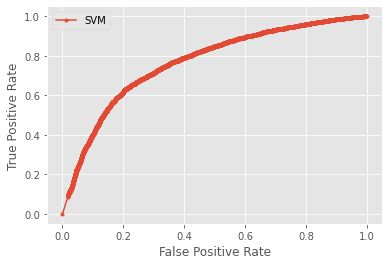

In [198]:
# roc curve and auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

std_scl = StandardScaler()
scl_obj = std_scl.fit(X_train)

X_train_scaled = scl_obj.transform(X_train)
X_test_scaled = scl_obj.transform(X_test) 

model.fit(X_train, y_train)

# predict probabilities
svm_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
svm_probs = svm_probs[:, 1]
# calculate scores
svm_auc = roc_auc_score(y_test, svm_probs)
# summarize scores\
print('SVM Model ROC AUC=%.3f' % (svm_auc))
# calculate roc curves
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
# plot the roc curve for the model
pyplot.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Find probability threshold for best accuracy

In [199]:
svm_probs

array([0.43619674, 0.56858624, 0.37566759, ..., 0.34705585, 0.45247799,
       0.75793575])

In [200]:
alphas = np.arange(0, 1, .1)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))


alpha 0.000000 : accuracy=0.560
alpha 0.100000 : accuracy=0.560
alpha 0.200000 : accuracy=0.562
alpha 0.300000 : accuracy=0.608
alpha 0.400000 : accuracy=0.689
alpha 0.500000 : accuracy=0.707
alpha 0.600000 : accuracy=0.683
alpha 0.700000 : accuracy=0.622
alpha 0.800000 : accuracy=0.561
alpha 0.900000 : accuracy=0.511


### tune a little finer

In [201]:
alphas = np.arange(.4, .6, .01)
for alpha in np.nditer(alphas):
    y_hat = list(map(lambda y_prob: 1 if y_prob > alpha else 0, svm_probs))
    acc = mt.accuracy_score(y_test, y_hat)
    print('alpha %f : accuracy=%.3f' % (alpha, acc))



alpha 0.400000 : accuracy=0.689
alpha 0.410000 : accuracy=0.694
alpha 0.420000 : accuracy=0.699
alpha 0.430000 : accuracy=0.703
alpha 0.440000 : accuracy=0.705
alpha 0.450000 : accuracy=0.708
alpha 0.460000 : accuracy=0.710
alpha 0.470000 : accuracy=0.710
alpha 0.480000 : accuracy=0.709
alpha 0.490000 : accuracy=0.708
alpha 0.500000 : accuracy=0.707
alpha 0.510000 : accuracy=0.706
alpha 0.520000 : accuracy=0.707
alpha 0.530000 : accuracy=0.705
alpha 0.540000 : accuracy=0.705
alpha 0.550000 : accuracy=0.703
alpha 0.560000 : accuracy=0.701
alpha 0.570000 : accuracy=0.695
alpha 0.580000 : accuracy=0.692
alpha 0.590000 : accuracy=0.688
